# SASAP Network Generation

In order to calculate distance in Alaska, we need to build a full network

## Generating the River Network

I'll need to go back and describe what I did to build the river network. That will be fun.

Input data:

* River network for US side came from [here](https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpwater#chpwater) in the "Hydrographic Geodatabase - Alaska, One Million-Scale" ([download link](https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Hydrography/hydrakm010g.gdb_nt00894.tar.gz)). It's the layer called "`hydrakm010g Stream`".
* Canadian streams came from IJC? Links and documentation? Second order and up, I think?
* processing
* uh, other stuff

Second order and greater for display:

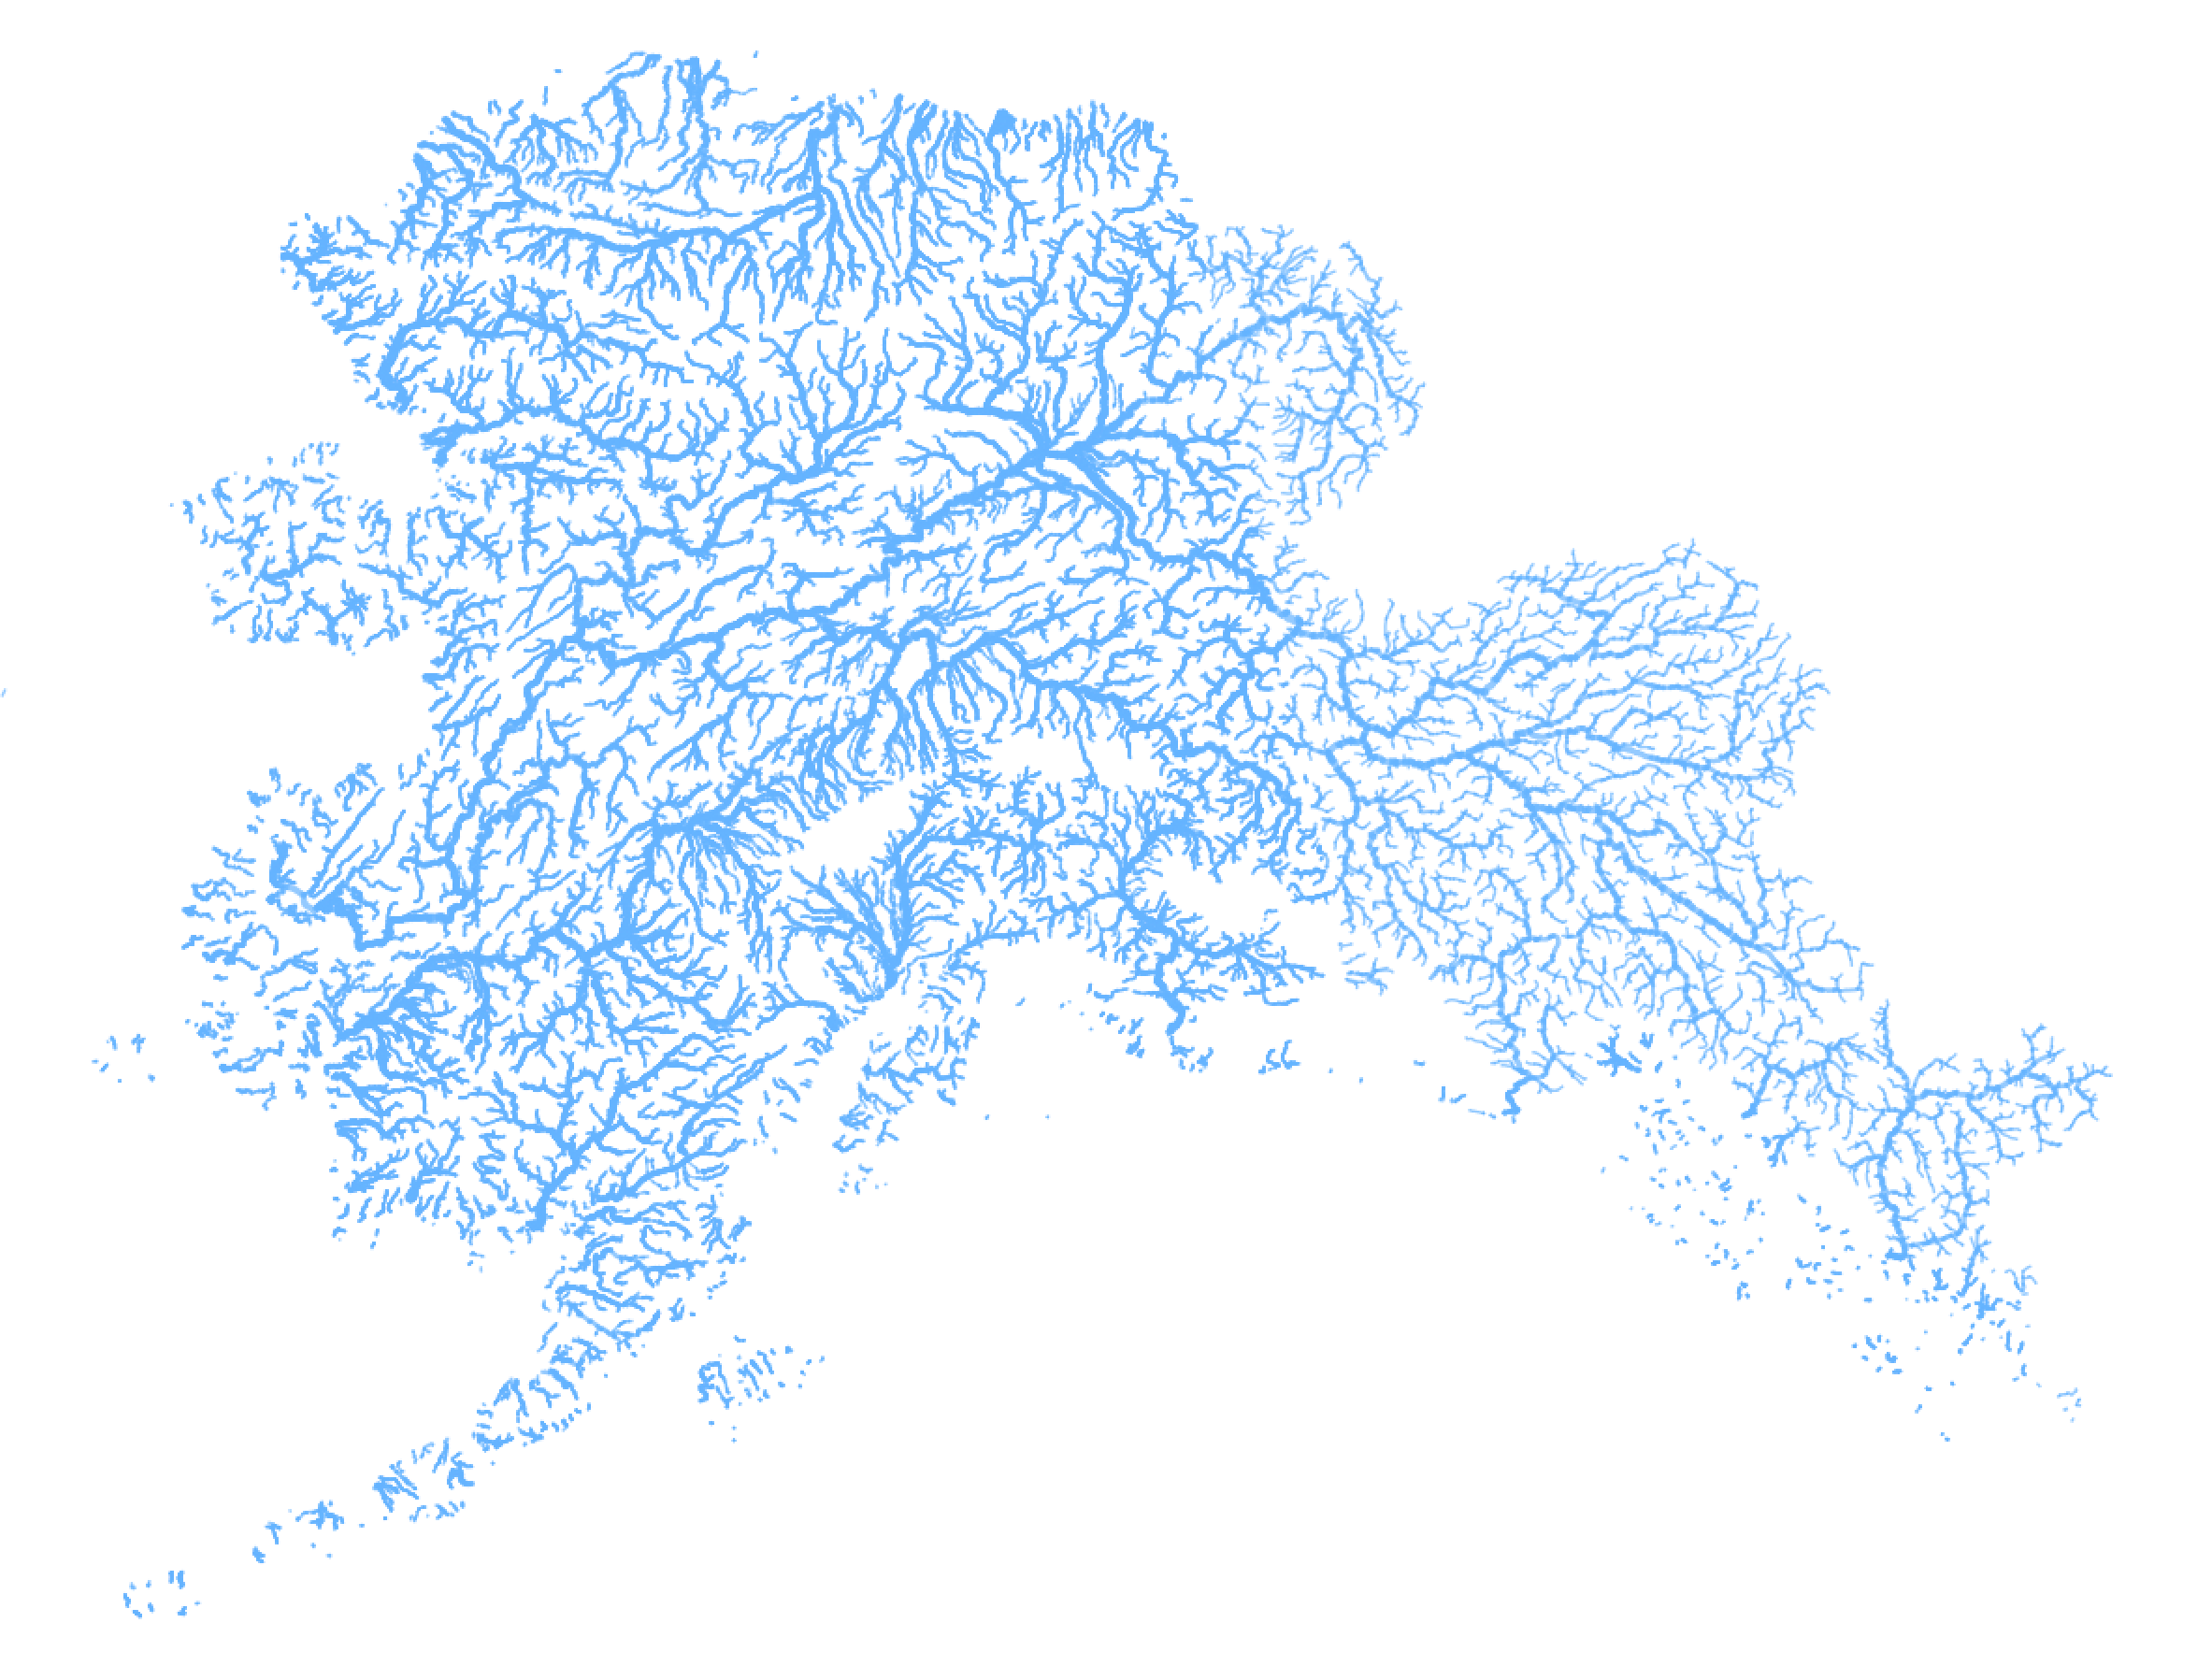

## Generating the Coastal Network

### Choosing a Coastline and Making a Polygon

I need to choose a coastline that gets the rivermouths as close to the coast as possible. Unfortunately, I can't find any polygons that really fit the bill, so I'll be using a line to generate a polygon. I considered the National Map Hydrography data (I think that's what it's called, the terminology is baffling) but it didn't treat the coastline exactly the same. The main problem is that the river mouths are located very far up the estuaries in my river data, so I need a coastline that goes all the way up there.

Long story short, I think we'll base the coast polygon off of the coastline feature ("`hydrakm010g Coastline`") found [here](https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpwater#chpwater) in the "Hydrographic Geodatabase - Alaska, One Million-Scale" [geodatabase](https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Hydrography/hydrakm010g.gdb_nt00894.tar.gz). This coastline is from the same dataset as the US portion of the river network, so it should (in theory) line up well with the river mouths. That's the good news.

The bad news is two-fold:

1. It's a line feature
2. It's high resolution

So, we'll need to convert it to a polygon. That means we'll have to do a bunch of stuff "by hand" in QGIS. I'll try to take notes on that below. The high resolution part means that it will have heaps of verticies. The more vertices it has, the longer the network will take to build. ...and the longer it'll take to actually do the distance calculations. I'll try simplifying the coast a bit once I've got a polygon, but that's got it's own set of problems. Simplifying will probably end up moving the coastline just enough that the rivermouth verticies no longer connect directly to the coast.

### Polygon Build Steps

1. Copy `hydrakm010g Coastline` to a shapefile and reproject to 3338
2. Then copy that to a shapefile called `CoastLinePolyBuild.shp`.
3. ~~Delete the parts of the coast that I don't want from that shapefile~~ (took too long)
4. Create an empty shapefile called `CoastlinePolyBuild2.shp` and copy the line segments I want to keep, giving them matching ids when they should be included in a single polygon
5. Add on a line segment that is a super rough outline of north america to make sure no paths can be calculated that cross land.
6. Turn single parts to multiparts based on id (`QGIS >> Vector >> Geometry Tools >> Singlepart to multipart`)
7. Use "Merge Lines" from processing toolbox to merge multilines into lines (this is required so that the vertex order makes sense for conversion to polygons)
8. Convert lines to polygons (`SASAP_Coastline_Polygon.shp`).

## Building a Coastal Network from the Coast Polygon

The following code was used to create the coastal network. Even with the geometry simplified to 1 km and running on 38 cores, it took many hours (6 or so?). It's a big old heap of calculations.

In [106]:
from IPython.display import Markdown

with open('SASAP_Coast_Build.py', 'r') as myfile:
    code = myfile.read()
Markdown("```python \n" + code + "\n```")

```python 
import pandas as pd
import geopandas as gpd
import os
from pyriv.coastal import Land
import networkx as nx

## Setup: ######
data_dir = '/home/shares/scientist/pyriv/shapefiles/'
fullpath = lambda s: os.path.join(data_dir, s)
full_land_fn = fullpath('SASAP_Coastline_Polygon.shp')
simp_num = 1000
n_processors = 38

land_out_fn = fullpath('SASAP_coast_poly{}m.shp'.format(simp_num))
gpic_out_fn = fullpath('SASAP_coast{}m.gpickle'.format(simp_num))

# read in the full resolution land shapefile
full_land = gpd.read_file(full_land_fn)
# dump small polygons and simplify the remains
lowres_land = full_land.set_geometry(full_land.simplify(simp_num).buffer(0))
lowres_land.to_file(land_out_fn)
# generate the graph
lnd = Land(land_out_fn)
ecgraph = lnd.graph(n_jobs=n_processors)
nx.write_gpickle(ecgraph, gpic_out_fn)
```

## Joining the River Network and the Coastal Network

This is a lot easier when the rivers and the coastline come from the same data source AND the coastline doesn't get simplified. In those cases, the end points of the river are (or are supposed to be) coincident with nodes on the coastline and, therefore, nodes on the coastal network. Then we can just join them and be happy.

However, in this case, the coastline has been simplified so many of the coastline nodes have been removed. So now we need to get a bit more creative. Here's the steps:

1. Identify all deadend nodes in the river network
2. Separate those deadends into three categories:
    1. Ocean nodes: deadends which are not within the land polygon
    2. River Mouths: deadends on land but within some distance (1 km, in this case) from the coastline
    3. Inland deadends: deadends on land but farther than threshold distance
3. Connect ocean nodes to coastal network
4. Complete the path for rivermouths with a straight segment to the nearest coastline
5. Prune paths that lead to inland deadends

In [6]:
%pylab inline
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import pyriv
from pyriv import rg_light as rgl
import os

data_dir = '/home/shares/scientist/pyriv/shapefiles/'
fp = lambda s: os.path.join(data_dir, s)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
lndfn = fp('SASAP_coast_poly1000m.shp')
lndnxfn = fp('SASAP_coast1000m.gpickle')
lnddf = gpd.read_file(lndfn)

The `riv_mouth_buffer` argument sets distance at which ends are considered coastal or not.

In [46]:
%%time
rgr = rgl.RiverGraph(data=fp('sasap_rivs_connected.shp'), coastline=lnddf, riv_mouth_buffer=4000)

CPU times: user 44 s, sys: 4.64 s, total: 48.6 s
Wall time: 48.6 s


In [47]:
rgends = rgr.deadend_gdf()

In [48]:
rgends['end_is_on'] = rgends.within(lnddf.unary_union).map({True: 'Land', False: 'Ocean'})

In [107]:
rgends.head()

,geometry,is_coastal,end_type,end_is_on
0,POINT (-379860.3187583779 1922551.521588362),True,Coastal,Land
1,POINT (1070453.9823073 1055712.294317043),True,Coastal,Ocean
2,POINT (-678731.9106695992 586245.4047647446),True,Coastal,Ocean
3,POINT (-108358.3656240352 842225.6561565663),True,Coastal,Land
4,POINT (-54362.78303254677 892811.0564870107),True,Coastal,Land


These nodes can be added directly to the coastal network. (edges must be calculated to join, but there will be some that don't cross land)

713 nodes


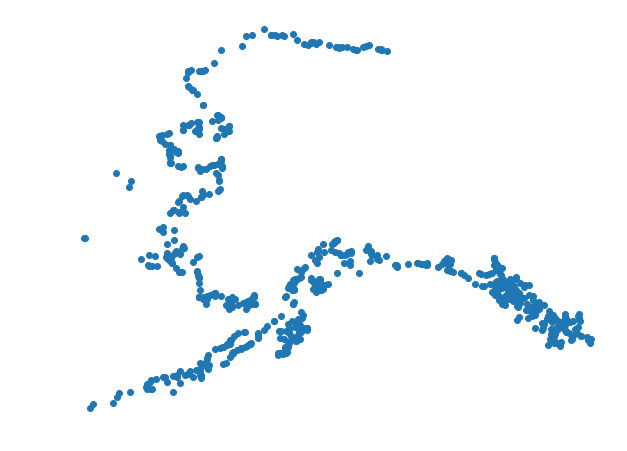

In [50]:
figsize(10,10)
ocean_nodes = rgends.query("end_is_on == 'Ocean'")
ax = ocean_nodes.plot()
ax.set_axis_off()
print "{} nodes".format(len(ocean_nodes))

These nodes are close enough that I'm willing to auto complete with the shortest line to the coast.

1490 nodes


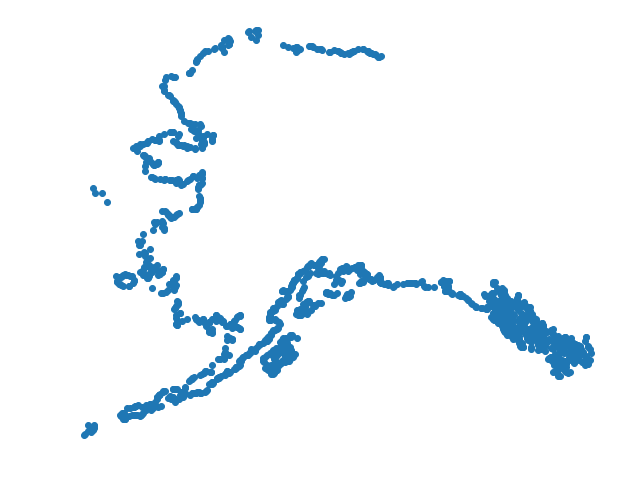

In [51]:
riv_mouths = rgends.query("end_is_on == 'Land' & end_type == 'Coastal'")
ax = riv_mouths.plot()
ax.set_axis_off()
print "{} nodes".format(len(riv_mouths))

In [96]:
riv_mouths.columns

Index([u'geometry', u'is_coastal', u'end_type', u'end_is_on'], dtype='object')

The `path_completion` method only works with single part polygon geodataframes, it fails on multiparts. So, I'll explode the land dataframe first.

In [103]:
sp_landdf = rgl.explode(lnddf)

In [104]:
%%time
auto_comp = lambda pth: rgl.path_completion(sp_landdf, pth)
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
auto_comp_df = gdf_from_geoms(riv_mouths.geometry.apply(auto_comp))
auto_comp_df.crs = riv_mouths.crs
auto_comp_df.to_file(fp('auto_complete.shp'))

CPU times: user 9.87 s, sys: 108 ms, total: 9.98 s
Wall time: 10.4 s


These nodes are further than `riv_mouth_buffer` from the coastline. The ones along the AK/Canada border are the smaller tributaries that I didn't think were worth the effort of manually joining. I don't think they will affect any paths that we're interested in for SASAP. I'm hoping that we can get away with ignoring the handful of others nearer the coast too. Ultimately, I may have to either increase the `riv_mouth_buffer` distance until they go away, or manually complete the important paths.

82 nodes


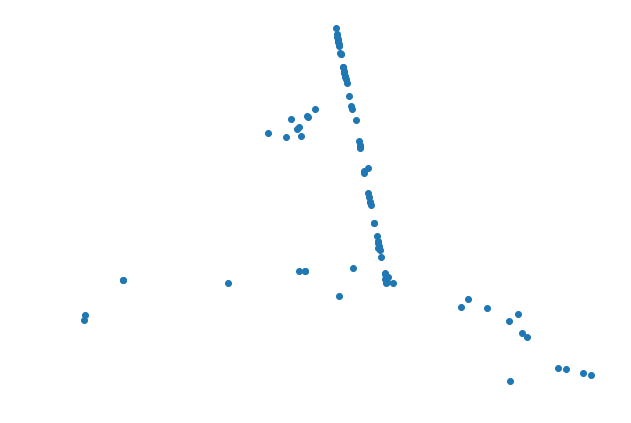

In [52]:
inland_dead = rgends.query("end_is_on == 'Land' & end_type == 'Inland'")
ax = inland_dead.plot()
ax.set_axis_off()
print "{} nodes".format(len(inland_dead))

In [56]:
asl_locs = gpd.read_file(fp("sasap_asl_locations.shp")).to_crs(epsg=3338)

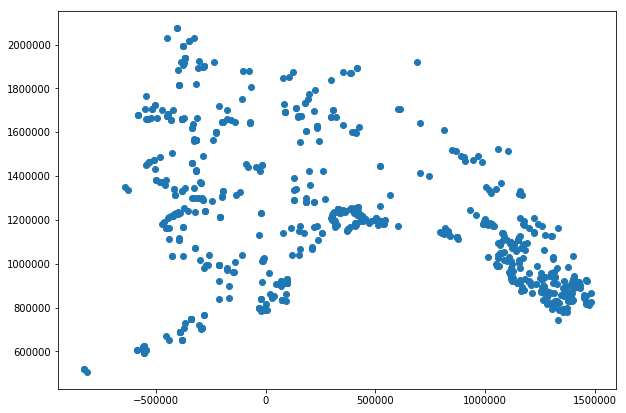

In [57]:
asl_locs.plot()

In [58]:
%%time
dedist = rgl.deadend_distances(asl_locs, rgr, node_distance=True)

CPU times: user 17min 41s, sys: 1.24 s, total: 17min 42s
Wall time: 17min 42s


In [82]:
dedistplus = dedist.copy()
dedistplus["pnt_is_on"] = dedistplus.within(lnddf.unary_union).map({True: "Land", False: "Water"})

In [83]:
dedistplus.set_geometry("path").iloc[2]

LoctnID                                          Ilnik River
LctnUnq                         Ilnik River-escapement-31620
geometry        POINT (-340895.5100628469 748153.6501201919)
path                                GEOMETRYCOLLECTION EMPTY
rivdist_km                                                 0
nearest_node     POINT (-336388.7698243427 750081.393458631)
node_dist                                            4901.72
pnt_is_on                                               Land
Name: 2, dtype: object

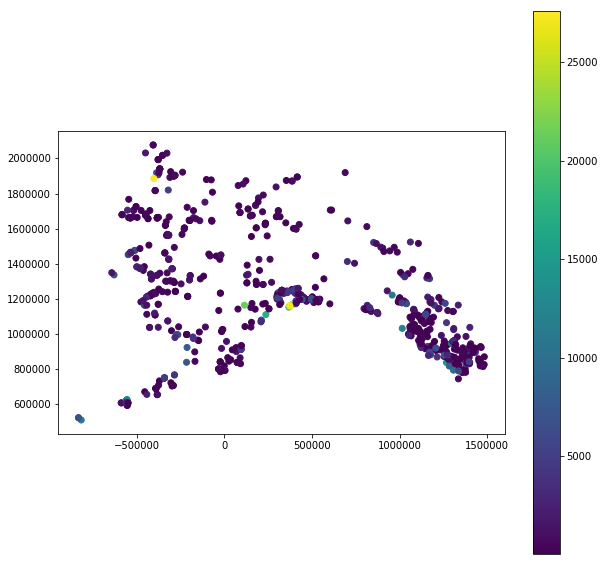

In [84]:
dedistplus.plot(column="node_dist", legend=True)

In [86]:
(dedistplus.rivdist_km == 0).sum()

224

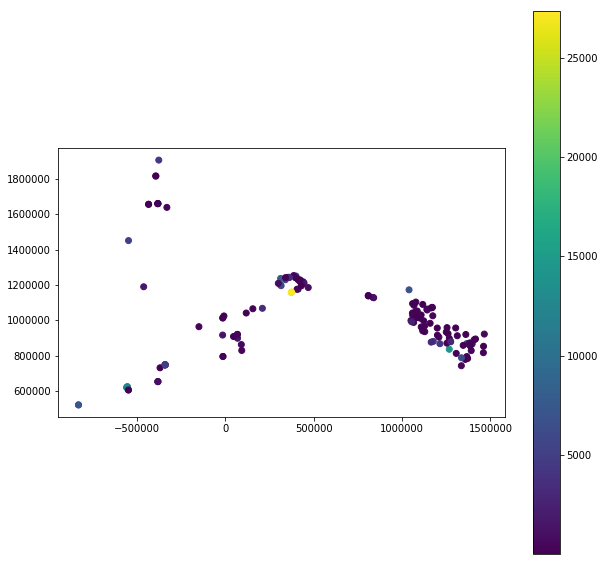

In [90]:
dedistplus.query("rivdist_km==0 & pnt_is_on=='Land'").plot(column="node_dist", legend=True)

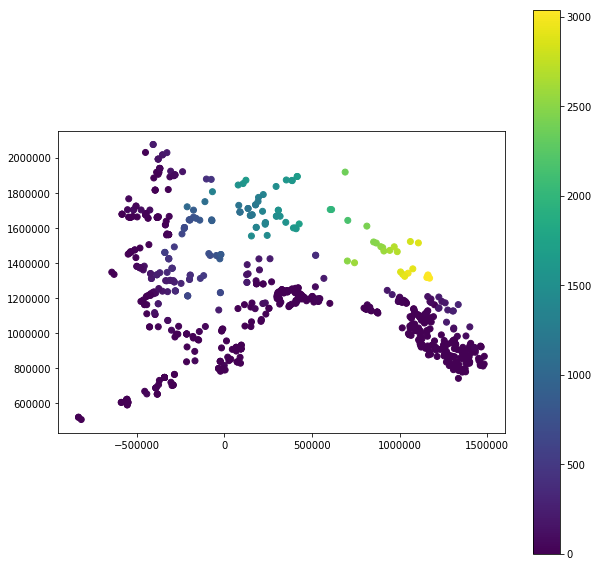

In [75]:
dedist.plot(column="rivdist_km", legend=True)

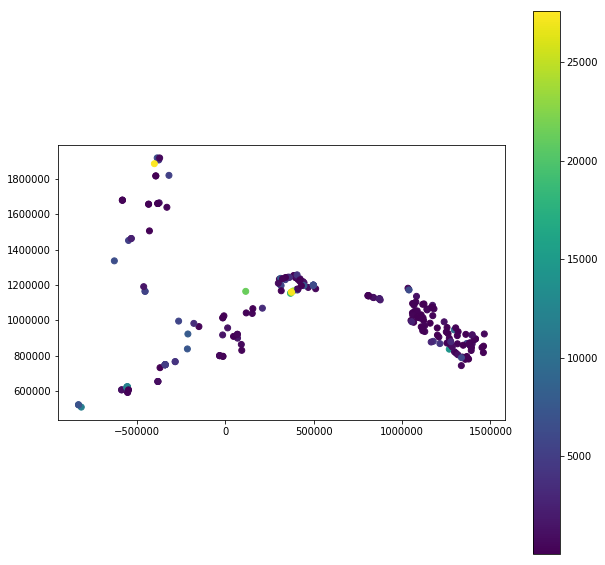

In [78]:
dedist.query("rivdist_km == 0").plot(column="node_dist", legend=True)

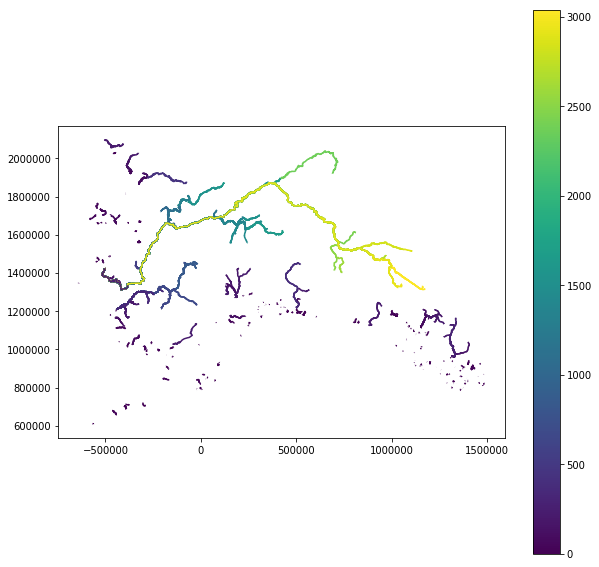

In [81]:
dedist.set_geometry("path").plot(column="rivdist_km", legend=True)

In [92]:
dedistplus.columns

Index([     u'LoctnID',      u'LctnUnq',     u'geometry',         u'path',
         u'rivdist_km', u'nearest_node',    u'node_dist',    u'pnt_is_on'],
      dtype='object')

In [95]:
dedistplus.query("rivdist_km != 0").set_geometry("path").drop(["geometry","nearest_node"], axis="columns").to_file(fp("paths_dev.shp"))